# Reconocedor de lengua de signos

Vamos a desarrollar una red que reconozca lengua de signos. Para ello, vamos a utilizar un dataset contenido en nuestra cuenta de Google Drive. Antes, debemos montar nuestro sistema de archivos de Google Drive para hacerlo accesible desde este *notebook*. Google nos solicitará permiso, tenemos que copiar y pegar el código que nos suministra.

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
from PIL import Image
import os

'''

def resize_images_in_directory(directorio_imagenes, nuevas_dimensiones, resize=True):
    # Filtrar solo los archivos de imagen (puedes ajustar las extensiones según tus necesidades)
    extensiones_de_imagen = ['.jpg', '.jpeg', '.png', '.gif', '.bmp']

    # Obtener la lista de archivos en el directorio
    archivos = os.listdir(directorio_imagenes)
    archivos_de_imagen = [archivo for archivo in archivos if any(archivo.endswith(extension) for extension in extensiones_de_imagen)]

    # Iterar a través de los archivos de imagen en el directorio
    for archivo_imagen in archivos_de_imagen:
        ruta_completa = os.path.join(directorio_imagenes, archivo_imagen)
        try:
            with Image.open(ruta_completa) as img:
                dimensiones = img.size
                if dimensiones != nuevas_dimensiones and resize:
                    img = img.resize(nuevas_dimensiones, Image.ANTIALIAS)
                    img.save(ruta_completa)  # Guardar la imagen redimensionada
                    print(f'Imagen redimensionada: {archivo_imagen}, Dimensiones: {nuevas_dimensiones}')
                else: 
                    print(f'Imagen: {archivo_imagen}, Dimensiones: {dimensiones}')                
        except Exception as e:
            print(f'Error al procesar {archivo_imagen}: {str(e)}')

# Lista de directorios que contienen las imágenes
directorios_imagenes = [
    './datasets/coins_no_augm/all/1c/',
    './datasets/coins_no_augm/all/2c/',
    './datasets/coins_no_augm/all/5c/',
    './datasets/coins_no_augm/all/10c/',
    './datasets/coins_no_augm/all/20c/',
    './datasets/coins_no_augm/all/50c/',
    './datasets/coins_no_augm/all/1e/',
    './datasets/coins_no_augm/all/2e/'
]

# Dimensiones deseadas
nuevas_dimensiones = (200, 200)

# Redimensionar imágenes en los directorios
for directorio_imagenes in directorios_imagenes:
    print(f'Procesando directorio: {directorio_imagenes}')
    resize_images_in_directory(directorio_imagenes, nuevas_dimensiones, resize=True)
'''

"\n\ndef resize_images_in_directory(directorio_imagenes, nuevas_dimensiones, resize=True):\n    # Filtrar solo los archivos de imagen (puedes ajustar las extensiones según tus necesidades)\n    extensiones_de_imagen = ['.jpg', '.jpeg', '.png', '.gif', '.bmp']\n\n    # Obtener la lista de archivos en el directorio\n    archivos = os.listdir(directorio_imagenes)\n    archivos_de_imagen = [archivo for archivo in archivos if any(archivo.endswith(extension) for extension in extensiones_de_imagen)]\n\n    # Iterar a través de los archivos de imagen en el directorio\n    for archivo_imagen in archivos_de_imagen:\n        ruta_completa = os.path.join(directorio_imagenes, archivo_imagen)\n        try:\n            with Image.open(ruta_completa) as img:\n                dimensiones = img.size\n                if dimensiones != nuevas_dimensiones and resize:\n                    img = img.resize(nuevas_dimensiones, Image.ANTIALIAS)\n                    img.save(ruta_completa)  # Guardar la imagen

¿Estoy realmente utilizando una GPU? Compruébalo en **Editar / Configuración del cuaderno** o **Entorno de ejecución / Cambiar tipo de entorno de ejecución**

In [3]:
import tensorflow as tf

# Verifica si TensorFlow tiene acceso a la GPU
physical_devices = tf.config.list_physical_devices('GPU')

if len(physical_devices) > 0:
    print(f"Keras/TensorFlow tiene acceso a la GPU -> {tf.test.gpu_device_name()}")
else:
    print("Keras/TensorFlow está utilizando la CPU.")


Keras/TensorFlow tiene acceso a la GPU -> /device:GPU:0


### Importaciones necesarias y configuraciones previas

In [ ]:
# IMPORTS --------------------------------------------------
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import random
import numpy as np
import tensorflow as tf
import os

# Establecer una semilla para reproducibilidad
seed_value = 42
random.seed(seed_value)        # Semilla para Python
np.random.seed(seed_value)     # Semilla para NumPy
tf.random.set_seed(seed_value) # Semilla para TensorFlow/Keras

### Data augmentation

In [6]:
'''

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras_preprocessing.image import load_img, img_to_array



image_size = (200, 200) 
batch_size = 16

# Configuración del generador de aumento de datos
data_augmentation = ImageDataGenerator(
    rescale=1./255,                 # Normalización de los valores de píxeles
    rotation_range=40,              # Grados de rotación aleatoria
    width_shift_range=0.1,          # Desplazamiento horizontal aleatorio
    height_shift_range=0.1,         # Desplazamiento vertical aleatorio
    shear_range=0.1,                # Cizalla aleatoria
    zoom_range=0.1,                 # Rango de zoom aleatorio
    channel_shift_range=5,         # Cambios aleatorios en los canales de colores
    brightness_range=[0.8,1.2],     # Rango de brillo aleatorio
    horizontal_flip=True,           # Activar volteo horizontal
    vertical_flip=True,             # Activar volteo vertical
    fill_mode='nearest'             # Modo de llenado para cuando se aplican transformaciones espaciales
)

# Directorios de entrenamiento y validación
train_dir = './datasets/coins_final/train'
valid_dir = './datasets/coins_final/valid'

# Directorios de salida para las imágenes aumentadas
augmented_train_dir = './datasets/coins_final/augmented_train'
augmented_valid_dir = './datasets/coins_final/augmented_valid'

# Función para guardar las imágenes aumentadas
def save_augmented_images(directory, augmented_directory, generator, num_images_per_file=5):
    # Crear el directorio si no existe
    if not os.path.exists(augmented_directory):
        os.makedirs(augmented_directory)
    
    for subdir in os.listdir(directory):
        subdirectory = os.path.join(directory, subdir)
        if os.path.isdir(subdirectory):
            augmented_subdir = os.path.join(augmented_directory, subdir)
            if not os.path.exists(augmented_subdir):
                os.makedirs(augmented_subdir)
            
            for file in os.listdir(subdirectory):
                file_path = os.path.join(subdirectory, file)
                image_obj = load_img(file_path)
                image_array = img_to_array(image_obj)
                image_array = image_array.reshape((1,) + image_array.shape)
                
                # Generar nuevas imágenes
                i = 0
                for batch in generator.flow(image_array, batch_size=1, save_to_dir=augmented_subdir, save_prefix=subdir, save_format='jpeg'):
                    i += 1
                    if i >= num_images_per_file:
                        break  # Guardar 5 imágenes y luego continuar con la siguiente imagen

# Aplicar aumento de datos al conjunto de entrenamiento y validación
save_augmented_images(train_dir, augmented_train_dir, data_augmentation)
save_augmented_images(valid_dir, augmented_valid_dir, data_augmentation)


# Creación de los generadores
train_gen = data_augmentation.flow_from_directory(
    train_dir,
    target_size=image_size,  # Asegúrate de que coincida con el tamaño de entrada de tu modelo
    batch_size=batch_size,
    class_mode='categorical'
)

valid_gen = data_augmentation.flow_from_directory(
    valid_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)
'''


"\n\nfrom keras.preprocessing.image import ImageDataGenerator\nfrom keras.preprocessing import image\nfrom keras_preprocessing.image import load_img, img_to_array\n\n\n\nimage_size = (200, 200) \nbatch_size = 16\n\n# Configuración del generador de aumento de datos\ndata_augmentation = ImageDataGenerator(\n    rescale=1./255,                 # Normalización de los valores de píxeles\n    rotation_range=40,              # Grados de rotación aleatoria\n    width_shift_range=0.1,          # Desplazamiento horizontal aleatorio\n    height_shift_range=0.1,         # Desplazamiento vertical aleatorio\n    shear_range=0.1,                # Cizalla aleatoria\n    zoom_range=0.1,                 # Rango de zoom aleatorio\n    channel_shift_range=5,         # Cambios aleatorios en los canales de colores\n    brightness_range=[0.8,1.2],     # Rango de brillo aleatorio\n    horizontal_flip=True,           # Activar volteo horizontal\n    vertical_flip=True,             # Activar volteo vertical\n  

In [8]:
# DATA SOURCE --------------------------------------------------
# '''
image_size = (200, 200) 
batch_size = 64
data_dir = os.path.join('..','datasets', 'coins_final', 'augmented_all')


train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=data_dir,
    validation_split=0.2,
    subset="training",
    seed=seed_value,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=data_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed_value,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)
# '''

Found 6279 files belonging to 8 classes.
Using 5024 files for training.
Found 6279 files belonging to 8 classes.
Using 1255 files for validation.


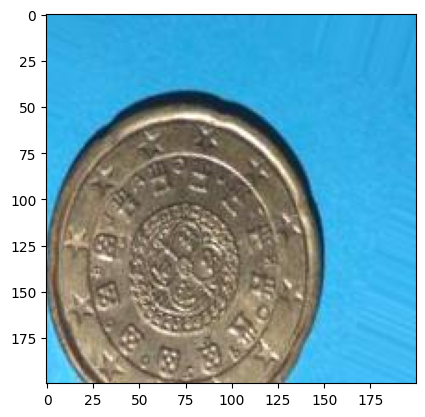

In [9]:
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

%matplotlib inline

pil_im = Image.open('../datasets/coins_final/augmented_all/20c/20c_0_1703.jpeg', 'r')
imshow(np.asarray(pil_im))

In [10]:
# MODEL --------------------------------------------------

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Rescaling, Flatten
from tensorflow.keras.callbacks import EarlyStopping

model = keras.Sequential()

model.add(Rescaling(scale=1./255.0,
                    offset=-1,
                    input_shape=(200,200,3)))

model.add(Conv2D(32, kernel_size=(4, 4), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(4, 4), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(4, 4), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.45))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))

model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])


In [11]:
# TRAINING --------------------------------------------------

epochs = 100

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10, restore_best_weights=True)

h = model.fit(
        train_ds, # train_gen, 
        epochs=epochs,
        validation_data=val_ds,
        callbacks = [es],
        # steps_per_epoch=200
)

Epoch 1/100
79/79 [==============================] - 19s 133ms/step - loss: 1.9176 - accuracy: 0.2191 - val_loss: 1.6420 - val_accuracy: 0.3371
Epoch 2/100
79/79 [==============================] - 9s 106ms/step - loss: 1.5544 - accuracy: 0.3746 - val_loss: 1.4439 - val_accuracy: 0.3841
Epoch 3/100
79/79 [==============================] - 8s 95ms/step - loss: 1.3590 - accuracy: 0.4407 - val_loss: 1.1929 - val_accuracy: 0.5570
Epoch 4/100
79/79 [==============================] - 7s 93ms/step - loss: 1.1866 - accuracy: 0.5283 - val_loss: 1.0106 - val_accuracy: 0.6215
Epoch 5/100
79/79 [==============================] - 7s 92ms/step - loss: 1.0299 - accuracy: 0.6105 - val_loss: 1.0913 - val_accuracy: 0.5896
Epoch 6/100
79/79 [==============================] - 8s 98ms/step - loss: 0.9646 - accuracy: 0.6320 - val_loss: 0.8371 - val_accuracy: 0.6558
Epoch 7/100
79/79 [==============================] - 8s 106ms/step - loss: 0.8838 - accuracy: 0.6545 - val_loss: 0.7438 - val_accuracy: 0.7084
Ep

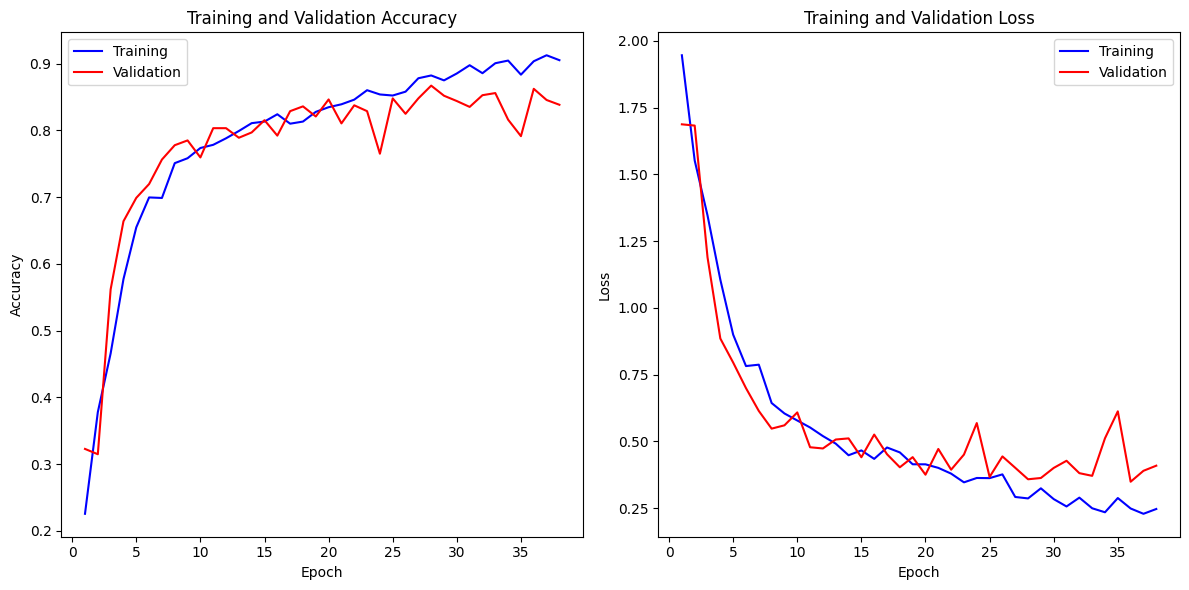

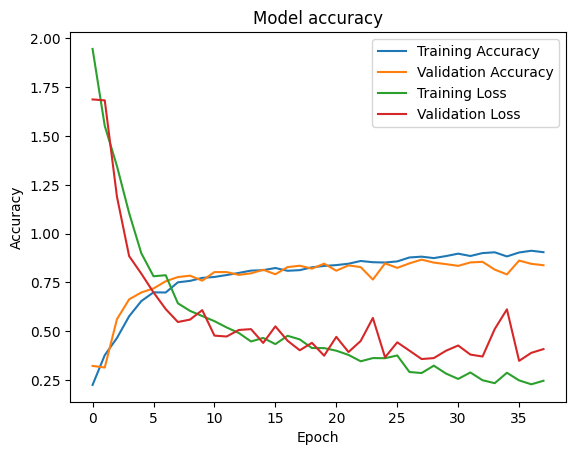

In [11]:
import matplotlib.pyplot as plt

def generatePlot(history):
    # Extracción de datos
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Creación del gráfico de accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training')
    plt.plot(epochs, val_acc, 'r', label='Validation')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Creación del gráfico de loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training')
    plt.plot(epochs, val_loss, 'r', label='Validation')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()
    

# Plots separados    
generatePlot(h)

# Plot conjunto
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy','Training Loss','Validation Loss'], loc='upper right')
plt.show()

## Evaluación de los resultados

1/1 [==============================] - 0s 17ms/step


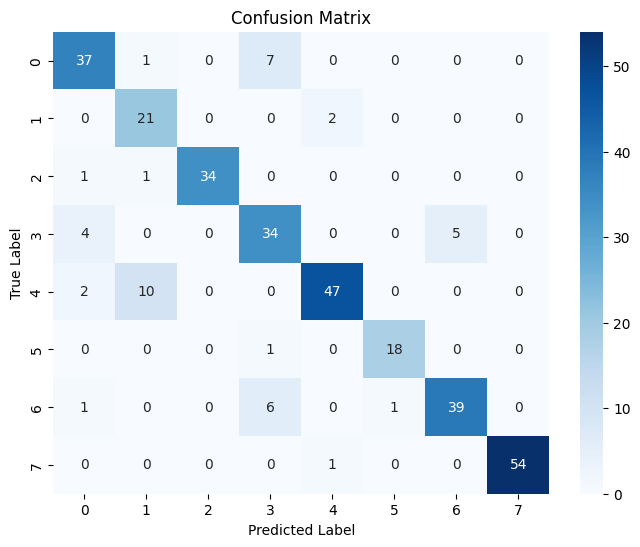

              precision    recall  f1-score   support

           0     0.8222    0.8222    0.8222        45
           1     0.6364    0.9130    0.7500        23
           2     1.0000    0.9444    0.9714        36
           3     0.7083    0.7907    0.7473        43
           4     0.9400    0.7966    0.8624        59
           5     0.9474    0.9474    0.9474        19
           6     0.8864    0.8298    0.8571        47
           7     1.0000    0.9818    0.9908        55

    accuracy                         0.8685       327
   macro avg     0.8676    0.8782    0.8686       327
weighted avg     0.8814    0.8685    0.8716       327



In [229]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

#for x, y in val_ds:
#  print(len(y))


results = np.concatenate([(y, model.predict(x=x)) for x, y in val_ds], axis=1)

predictions = np.argmax(results[0], axis=1)
labels = np.argmax(results[1], axis=1)

cf_matrix = confusion_matrix(labels, predictions)

# Crear un mapa de calor con etiquetas en los ejes
plt.figure(figsize=(8, 6))
sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="Blues")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


print(classification_report(labels, predictions, digits = 4))

In [14]:
img = keras.preprocessing.image.load_img(
    './jellyfish/train/Aurelia_0023_jpg.rf.86edde0ccb85469a7108a278caa558fc.jpg', target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
print(np.argmax(predictions[0]))

1/1 [==============================] - 0s 323ms/step
1
